In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings

warnings.filterwarnings("ignore")

## **Data Preprocessing**

In [2]:
df = pd.read_csv('./train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9945 entries, 0 to 9944
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           9945 non-null   object 
 1   Ease_Score      9945 non-null   float64
 2   Download_Count  9945 non-null   int64  
 3   Index           9945 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 310.9+ KB


In [3]:
df[['Ease_Score','Download_Count']].describe()

,Ease_Score,Download_Count
count,9945.000000,9945.000000
mean,70.758904,192.865661
std,12.006392,1344.537166
min,0.700000,21.000000
25%,62.500000,64.000000
50%,71.800000,86.000000
75%,80.400000,134.000000
max,99.700000,80680.000000


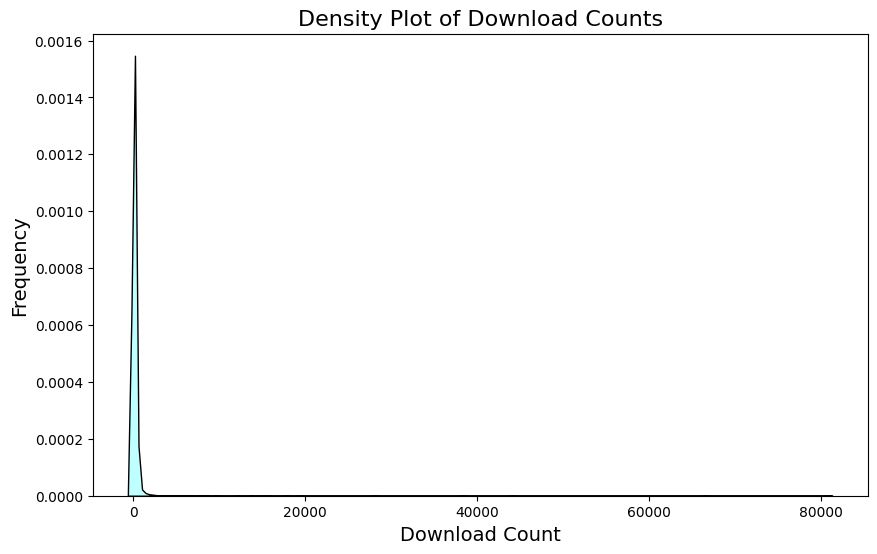

In [4]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(df['Download_Count'], color='cyan',edgecolor='black', shade=True)
plt.title('Density Plot of Download Counts', fontsize=16)
plt.xlabel('Download Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

Từ kết quả trực quan trên ta thấy biểu đồ lệch phải nặng, nên ta xét đến việc xử lý các giá trị ngoại lai, thực hiện biến đổi dữ liệu.

In [5]:
Q1 = df['Download_Count'].quantile(0.25)
Q3 = df['Download_Count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
df = df[(df['Download_Count'] >= lower_bound) & (df['Download_Count'] <= upper_bound)]
df.reset_index(drop=True,inplace=True)
df['Download_Count'] = np.log1p(df['Download_Count'])
df[['Ease_Score','Download_Count']].describe()

,Ease_Score,Download_Count
count,8915.000000,8915.000000
mean,70.917353,4.453274
std,11.953912,0.422819
min,0.700000,3.091042
25%,62.600000,4.143135
50%,72.100000,4.406719
75%,80.500000,4.731793
max,99.500000,5.480639


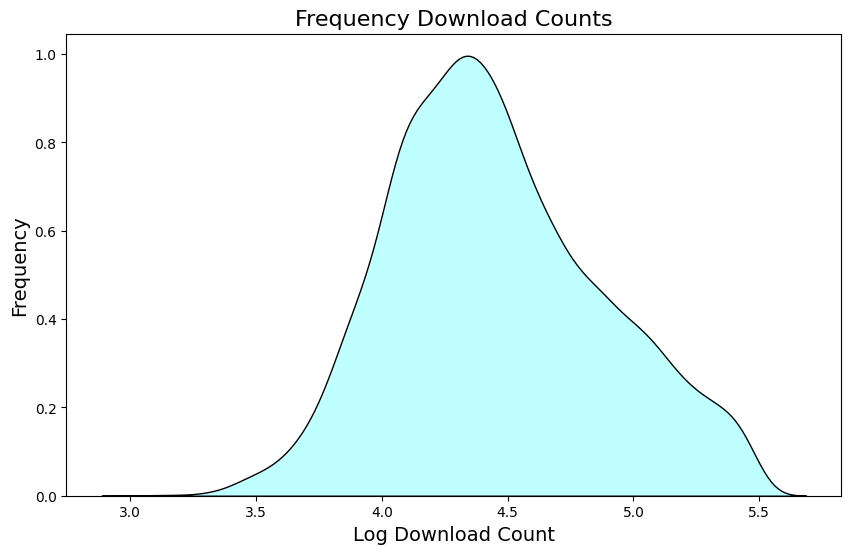

In [6]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Download_Count'], color='cyan', edgecolor='black',shade=True)
plt.title('Frequency Download Counts', fontsize=16)
plt.xlabel('Log Download Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

## **Natural Language Preprocessing**

In [7]:
df['Title'].head(10)

0                                    The Master Spirit
1                                 The Family on Wheels
2    Three Good Giants\nWhose Ancient Deeds are rec...
3    Drake's Road Book of the Grand Junction Railwa...
4    Facts and Speculations on the Origin and Histo...
5    Punch, or the London Charivari, Vol. 98, April...
6    Patriotic Song\r\nA book of English verse, bei...
7                              The Community Cook Book
8    Dog Breaking\r\nThe Most Expeditious, Certain,...
9    A Letter to the Kensington Canal Company on th...
Name: Title, dtype: object

Như đã thấy, tập dữ liệu chứa các dữ liệu dạng chuỗi chưa được chuẩn hóa. Để xây dựng dữ liệu correlation matrix giữa các đối tượng, việc xử lý các chuỗi này là nhu cầu cần thiết.  

Thực hiện các bước dữ liệu:
- Word Tokenization: thực hiện tách các dữ liệu dạng chuỗi thành từng đối tượng dạng chuỗi thành một tập các từ.
- Stop words Removal: thực hiện loại bỏ các từ thông dụng.
- Stemming: thực hiện chuẩn hóa các từ loại về dạng cơ bản của từ đó.

In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

### Word Tokenization

In [9]:
df['Processed_Title'] = df['Title'].apply(word_tokenize)

### Stopwords Removal

In [10]:
df['Processed_Title'] = df['Processed_Title'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

### Stemming

In [11]:
df['Processed_Title'] = df['Processed_Title'].apply(lambda tokens: [stemmer.stem(word)for word in tokens])

In [12]:
df['Processed_Title'] = df['Processed_Title'].apply(lambda tokens: ' '.join(tokens))

### Term Frequency-Inverse Document Frequency

Sử dụng **TfidfVectorizer** để chuyển đổi văn bản thành biểu diễn số dưới dạng ma trận **TF-IDF** (Term Frequency-Inverse Document Frequency) với:
- **TF** (Term Frequency): Đo lường tần suất của một từ xuất hiện trong một tài liệu so với tổng số từ trong tài liệu đó.  
- **IDF** (Inverse Document Frequency): Đo lường mức độ phổ biến của một từ trên toàn bộ tập dữ liệu. Từ càng xuất hiện ở nhiều tài liệu thì trọng số của nó càng thấp.


In [13]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['Processed_Title'])
sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
df['Popularity'] = kmeans.fit_predict(df[['Download_Count']])

## Recommendation system based on user needs.

Hệ thống đề xuất được xây dựng theo phương pháp Content-Based Filtering để đưa ra gợi ý những cuốn sách có nội dung tương tự. Ngoài ra hệ thống được bổ sung tính năng như lọc theo độ nổi tiếng và sắp xuất tăng hoặc giảm tùy thôi mức độ dễ dọc của từng cuốn sách.

In [15]:
def get_index(title,df=df):
    """
    Lấy ra vị trí của sách trong bộ dữ liệu.
    
    Args:
        title (str): Title của cuốn sách.
        df (pd.DataFrame): DataFrame chứa thông tin cụ thể của từng sách.
    
    Returns:
        pd.Index: Vị trí của cuốn sách trong bộ dữ liệu.
    """
    return df.index[df['Title'] == title][0]

In [16]:
def get_similar_books(book_title,sim_matrix=sim_matrix,df=df):
    """
    Lấy ra những cuốn sách có độ tương đồng với cuốn sách hiện tại.
    
    Args:
        book_title (str): Title của cuốn sách.
        sim_matrix (np.ndarray): Ma trận thể hiện độ tương quan của 1 đối tượng sách với tất cả đối tượng sách khác.
        df (pd.DataFrame): DataFrame chứa thông tin cụ thể của từng sách.
    
    Returns:
        pd.DataFrame: Danh sách sách có tương quan với sách được yêu cầu.
    """
    index = get_index(book_title)
    sim_books = pd.concat([pd.DataFrame(sim_matrix[index],columns=['Similarity']),df[['Ease_Score','Popularity']]],axis = 1) 
    return sim_books[sim_books['Similarity'] != 0]

In [17]:
def recommend_books(title,df=df,sim_matrix=sim_matrix,popularity_filter=None, sort_by_ease_score=None, top_n=10):
    """
    Hệ thống gợi ý sách với các bộ lọc và sắp xếp. Hệ thống lấy ra top_n cuốn sách có độ tương đồng cao 
    nhất. Người dùng có thêm lựa chọn lọc theo độ nổi tiếng hoặc có thể chọn sắp xếp tăng giảm theo độ
    dễ đọc tùy nhu cầu.
    
    Args:
        title (str): Title của cuốn sách.
        df (pd.DataFrame): DataFrame chứa thông tin cụ thể của từng sách.
        popularity_filter (int, optional): Lọc theo độ nổi tiếng (1: nổi tiếng, 0: chưa nổi tiếng, None: không lọc).
        sort_by_ease_score (str, optional): Sắp xếp theo Ease_Score ('asc' tăng dần, 'desc' giảm dần, None: không sắp xếp).
        top_n (int, optional): Số lượng sách cần gợi ý (mặc định là 10).
    
    Returns:
        pd.DataFrame: Danh sách sách được gợi ý theo thứ tự ưu tiên.
    """
    sim_data = get_similar_books(title)
    sim_data = sim_data.sort_values(by='Similarity',ascending=False)[1:top_n+1]
    
    if popularity_filter is not None:
        sim_data = sim_data[sim_data['Popularity'] == popularity_filter]

    if sort_by_ease_score == 'asc':
        sim_data = sim_data.sort_values(by='Ease_Score', ascending=True)
    elif sort_by_ease_score == 'desc':
        sim_data = sim_data.sort_values(by='Ease_Score', ascending=False)
        
    indices = sim_data.index
        
    return df['Title'].iloc[indices]

In [18]:
title_01 = "The Master Spirit"	
print(recommend_books(title_01))
print("\n")
print(recommend_books(title_01,sort_by_ease_score='asc'))
print("\n")
print(recommend_books(title_01,popularity_filter=1,sort_by_ease_score='asc',))

8270                        The World Masters
1000                  The Spirit of Christmas
2377                         Masters of Space
5238                              Master Race
6268               The Ministry of the Spirit
2856                      The Master's Violin
3599                          Master Sunshine
1339                     Masters of the Guild
7744    The Spirit of Place, and Other Essays
699                  The Spirit of Sweetwater
Name: Title, dtype: object


7744    The Spirit of Place, and Other Essays
6268               The Ministry of the Spirit
1000                  The Spirit of Christmas
8270                        The World Masters
3599                          Master Sunshine
2377                         Masters of Space
1339                     Masters of the Guild
2856                      The Master's Violin
699                  The Spirit of Sweetwater
5238                              Master Race
Name: Title, dtype: object


7744    The Spirit of 

In [19]:
title_02 = "The Believing Years"	
print(recommend_books(title_02))
print("\n")
print(recommend_books(title_02,sort_by_ease_score='asc'))
print("\n")
print(recommend_books(title_02,popularity_filter=1,sort_by_ease_score='desc'))

60                        The Cruise of the Make-Believes
4244                                 A Year in the Fields
8376                                     Three Years' War
7621                                 A Mother's Year Book
5367    History of the war in the Peninsula and in the...
6026    Twenty-Two Years a Slave, and Forty Years a Fr...
6134                                   The Locusts' Years
8738                             My Four Years in Germany
1479                                      One Year Abroad
4632                   A happy New Year, and other verses
Name: Title, dtype: object


5367    History of the war in the Peninsula and in the...
8738                             My Four Years in Germany
6026    Twenty-Two Years a Slave, and Forty Years a Fr...
1479                                      One Year Abroad
8376                                     Three Years' War
6134                                   The Locusts' Years
7621                                 A Moth

In [20]:
title_03 = "Dumps - A Plain Girl"	
print(recommend_books(title_03))
print("\n")
print(recommend_books(title_03,sort_by_ease_score='desc'))
print("\n")
print(recommend_books(title_03,popularity_filter=0,sort_by_ease_score='asc',))

8787                                        Plain English
2570                                 When They Were Girls
7976                                          Penny Plain
3340                             Plain Tales of the North
5354                                 Judith of the Plains
5839                           The Plain Man and His Wife
5036                                   A Bookful of Girls
4137                  The Girl Warriors: A Book for Girls
4767    The Geologic Story of the Great Plains\r\nA no...
4415                                 A Girl of the People
Name: Title, dtype: object


4415                                 A Girl of the People
7976                                          Penny Plain
3340                             Plain Tales of the North
5036                                   A Bookful of Girls
5354                                 Judith of the Plains
4137                  The Girl Warriors: A Book for Girls
8787                                       

In [21]:
ease_score_sort = None
popularity = None
top_n = 10

In [22]:
title = input("Enter title: ")

Enter title:  The Master Spirit


In [23]:
ease_score_sort = input("Sort: ")

Sort:  asc


In [24]:
popularity = int(input("Popularity: "))

Popularity:  1


In [25]:
top_n = int(input("Top: "))

Top:  3


In [26]:
print(recommend_books(title,sort_by_ease_score=ease_score_sort,popularity_filter=popularity,top_n=top_n))

1000    The Spirit of Christmas
8270          The World Masters
2377           Masters of Space
Name: Title, dtype: object
